# Create osm segment with Crime index from grids data

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:

# Define output folder path
intermediate_output_folder_path = os.path.join('..', '..', 'data','02_intermediate_output')

# Define data folder path
data_folder_path = os.path.join('..','..', 'data','01_input_data')

## load data

In [5]:
# load 10m osm buffer created in QGIS from input data folder
osm_path= os.path.join(data_folder_path, ' osm_roads_10m_buffer.gpkg')

osm = gpd.read_file(osm_path)

osm.head()

,osm_id,width,tunnel,layer,name,smoothness,surface,oneway,bridge,highway,geometry
0,4217292,None,None,None,Rua Vinícius de Moraes,None,asphalt,yes,None,residential,"MULTIPOLYGON (((684207.717 7457099.290, 684214..."
1,4217293,None,None,None,Rua Joana Angélica,None,asphalt,yes,None,residential,"MULTIPOLYGON (((683971.877 7456864.780, 683972..."
2,4217294,None,None,None,Rua Farme de Amoedo,None,asphalt,no,None,residential,"MULTIPOLYGON (((684471.412 7457422.082, 684470..."
3,4217295,None,None,None,Rua Teixeira de Melo,None,asphalt,yes,None,residential,"MULTIPOLYGON (((684623.508 7456822.403, 684623..."
4,4217297,None,None,None,Rua Maria Quitéria,None,asphalt,yes,None,residential,"MULTIPOLYGON (((683840.889 7457500.977, 683835..."


In [6]:
# load actual  osm street lines from input data folder
osm_lines_path= os.path.join(data_folder_path, 'osm_roads.gpkg')

osm_lines = gpd.read_file(osm_lines_path)

osm_lines.head()

,osm_id,width,tunnel,layer,name,smoothness,surface,oneway,bridge,highway,geometry
0,4217292,None,None,None,Rua Vinícius de Moraes,None,asphalt,yes,None,residential,"LINESTRING (-43.20285 -22.98436, -43.20285 -22..."
1,4217293,None,None,None,Rua Joana Angélica,None,asphalt,yes,None,residential,"LINESTRING (-43.20518 -22.98645, -43.20515 -22..."
2,4217294,None,None,None,Rua Farme de Amoedo,None,asphalt,no,None,residential,"LINESTRING (-43.20049 -22.98095, -43.20051 -22..."
3,4217295,None,None,None,Rua Teixeira de Melo,None,asphalt,yes,None,residential,"LINESTRING (-43.19874 -22.98678, -43.19876 -22..."
4,4217297,None,None,None,Rua Maria Quitéria,None,asphalt,yes,None,residential,"LINESTRING (-43.20657 -22.98051, -43.20664 -22..."


In [7]:
# load crime_index_grid from previous script
crime_index_grid_path= os.path.join(intermediate_output_folder_path, 'crime_index_grid.gpkg')

crime_index_grid = gpd.read_file(crime_index_grid_path)

crime_index_grid.head()

,Id,crime_index,geometry
0,0,0.000091,"MULTIPOLYGON (((623543.654 7466506.750, 623553..."
1,1,0.000090,"MULTIPOLYGON (((623542.434 7466324.100, 623540..."
2,2,0.000090,"MULTIPOLYGON (((623571.614 7466230.200, 623558..."
3,3,0.000090,"MULTIPOLYGON (((623718.395 7466708.231, 623757..."
4,4,0.000089,"MULTIPOLYGON (((623572.224 7466605.211, 623581..."


## crime index

Finding Street-Level Crime Index from Grid-Level Crime Index

In [8]:
joined_data = gpd.sjoin(osm, crime_index_grid, how="left", op="intersects")
joined_data = joined_data.dropna(subset=['crime_index'])
mean_scores = joined_data.groupby('osm_id')['crime_index'].mean().reset_index()
# mean_scores['crime_index'].fillna(0, inplace=True)

In [9]:
# Fit the scaler to the 'crime_index' column and transform it 0 to 1  range 
scaler = MinMaxScaler()
mean_scores['crime_index'] = scaler.fit_transform(mean_scores[['crime_index']])

## Plots

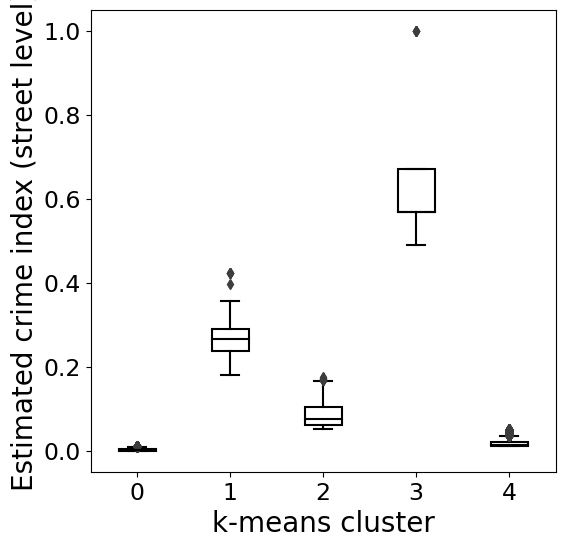

In [10]:
data = mean_scores[['crime_index']]
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(data)
# Add the cluster labels to the GeoDataFrame
mean_scores['cluster_label'] = labels
plt.figure(figsize=(6, 6))
sns.boxplot(x='cluster_label', y='crime_index', data=mean_scores, 
            boxprops=dict(facecolor='white', edgecolor='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), 
            medianprops=dict(color='black'), 
            width=0.4)

plt.xlabel('k-means cluster', fontsize=20)  
plt.ylabel('Estimated crime index (street level)', fontsize=20)  
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

In [11]:
osm_lines = osm_lines.to_crs("EPSG:31983") # convert to crs for length  calculation

osm_lines['length'] = osm_lines['geometry'].length  # calculate length of each line
 

In [12]:
# join safety score to actuial lines
osm_lines = osm_lines.merge(mean_scores[['osm_id', 'crime_index']], on='osm_id', how='left')
osm_lines.dropna(subset=['crime_index'], inplace=True)

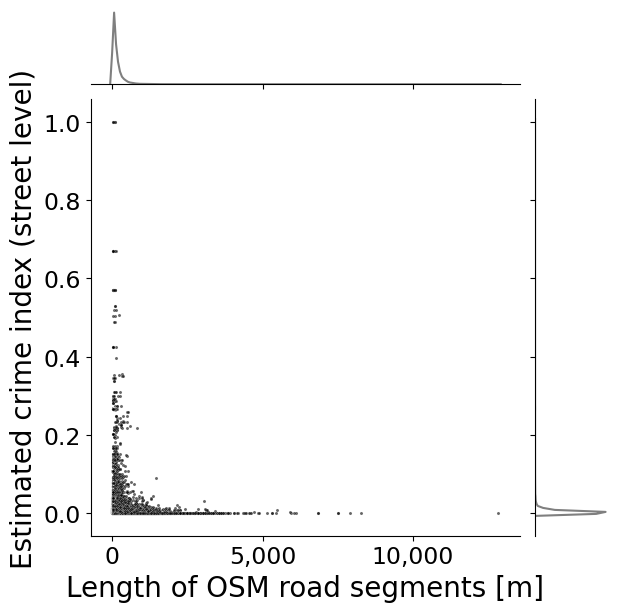

In [13]:

# define labels
xlabel = 'Length of OSM road segments [m]'
ylabel = 'Estimated crime index (street level)'

# Initialize the JointGrid
g = sns.JointGrid(data=osm_lines, x='length', y='crime_index')

# Define scatter plot 
scatter_kws = {"s": 5, "alpha": 0.6, "color": "black"}  # Small black dots with transparency

# Plot a scatter plot on the joint axes
g.plot_joint(sns.scatterplot, **scatter_kws)

# Plot KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, fill=False, color="black", alpha=0.5, legend=False)

g.set_axis_labels(xlabel, ylabel, fontsize=20)  # Increase x-axis label font size

# x and y axis labels with thousand separator
g.ax_joint.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
g.ax_joint.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))  # Assuming safety score can be a decimal

# Increase fontsize for axis ticks
g.ax_joint.tick_params(axis='x', labelsize=17)
g.ax_joint.tick_params(axis='y', labelsize=17)


desired_spacing = 5000 
g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(base=desired_spacing))

# Show the plot
plt.show()

## To visualise crime index on 10m buffer

In [12]:
osm_10m = osm.merge(mean_scores, on='osm_id', how='left')
nan_mask = osm_10m['crime_index'].isna()
if nan_mask.any():
    osm_with_means = osm_10m.dropna(subset=['crime_index'])
osm_10m.head()

,osm_id,width,tunnel,layer,name,smoothness,surface,oneway,bridge,highway,geometry,crime_index,cluster_label
0,4217292,None,None,None,Rua Vinícius de Moraes,None,asphalt,yes,None,residential,"MULTIPOLYGON (((684207.717 7457099.290, 684214...",0.008638,0.0
1,4217293,None,None,None,Rua Joana Angélica,None,asphalt,yes,None,residential,"MULTIPOLYGON (((683971.877 7456864.780, 683972...",0.007407,0.0
2,4217294,None,None,None,Rua Farme de Amoedo,None,asphalt,no,None,residential,"MULTIPOLYGON (((684471.412 7457422.082, 684470...",0.006688,0.0
3,4217295,None,None,None,Rua Teixeira de Melo,None,asphalt,yes,None,residential,"MULTIPOLYGON (((684623.508 7456822.403, 684623...",0.011186,4.0
4,4217297,None,None,None,Rua Maria Quitéria,None,asphalt,yes,None,residential,"MULTIPOLYGON (((683840.889 7457500.977, 683835...",0.006652,0.0


## save

Save the CSV to go into ORS and the GPKG for visualization.

In [90]:
save_path= os.path.join(intermediate_output_folder_path, 'crime_index_street.gpkg')


osm_10m.to_file(save_path, driver='GPKG')

# transform to 0 to 100 Range as ORS csv parametrs 

mean_scores['crime_index'] = mean_scores['crime_index'] * 100
mean_scores = mean_scores.drop(columns=['cluster_label'])
mean_scores.to_csv(save_path.replace('.gpkg', '.csv'), index=False)
